# COW (Coherent One-Way) QKD Protocol – Simulation & Structured Visualisation

This notebook implements a simple simulation of the **COW QKD protocol** and provides
a structured, dashboard-style visualisation to understand:
- How Alice prepares time-bin encoded pulses
- How the quantum channel (with or without Eve) affects them
- How decoy states help detect eavesdropping
- Final key agreement and error statistics


In [4]:
## Import libraries and define the COW_QKD class

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as mpatches

class COW_QKD:
    """
    Simple implementation of COW (Coherent One-Way) QKD Protocol

    The COW protocol uses time-bin encoding with weak coherent pulses.
    It can detect eavesdropping through visibility degradation.
    """

    def __init__(self, key_length=100, error_rate=0.0, eve_present=False):
        self.key_length = key_length
        self.error_rate = error_rate  # Channel noise
        self.eve_present = eve_present
        self.alice_sequence = []
        self.bob_sequence = []

    def alice_prepare(self):
        """
        Alice prepares the sequence of pulses.
        Encoding: 0 -> |1,0⟩, 1 -> |0,1⟩, decoy -> |1,1⟩
        """
        sequence = []
        for i in range(self.key_length):
            bit = random.randint(0, 1)
            # With some probability, insert decoy states
            if random.random() < 0.1:  # 10% decoy states
                sequence.append('D')  # Decoy state |1,1⟩
            else:
                sequence.append(bit)

        self.alice_sequence = sequence
        return sequence

    def channel_transmission(self, sequence):
        """
        Simulate quantum channel with potential eavesdropping.
        """
        transmitted = []

        for state in sequence:
            # Eve's intercept-resend attack
            if self.eve_present and random.random() < 0.5:
                # Eve measures randomly, causing errors
                if state == 'D':
                    # Decoy becomes non-decoy with high probability
                    transmitted.append(random.randint(0, 1))
                else:
                    # Eve might flip the bit
                    if random.random() < 0.5:
                        transmitted.append(1 - state if state != 'D' else state)
                    else:
                        transmitted.append(state)
            else:
                # Normal transmission with channel noise
                if random.random() < self.error_rate:
                    if state != 'D':
                        transmitted.append(1 - state)
                    else:
                        transmitted.append(state)
                else:
                    transmitted.append(state)

        return transmitted

    def bob_measure(self, sequence):
        """
        Bob performs measurements on received pulses.
        He measures both data bits and checks decoy states.
        """
        self.bob_sequence = sequence
        return sequence

    def decoy_check(self):
        """
        Check decoy states to detect eavesdropping.
        Returns error rate in decoy states.
        """
        decoy_errors = 0
        decoy_count = 0

        for i in range(len(self.alice_sequence)):
            if self.alice_sequence[i] == 'D':
                decoy_count += 1
                if self.bob_sequence[i] != 'D':
                    decoy_errors += 1

        if decoy_count == 0:
            return 0.0

        error_rate = decoy_errors / decoy_count
        return error_rate

    def sift_key(self, decoy_threshold=0.15):
        """
        Sift the key by removing decoy states and checking security.
        """
        decoy_error = self.decoy_check()

        print(f"Decoy state error rate: {decoy_error:.2%}")

        if decoy_error > decoy_threshold:
            print("⚠️ HIGH DECOY ERROR RATE - Eavesdropping detected!")
            print("Aborting key exchange for security.")
            return None

        # Extract data bits (non-decoy states)
        alice_key = []
        bob_key = []

        for i in range(len(self.alice_sequence)):
            if self.alice_sequence[i] != 'D':
                alice_key.append(self.alice_sequence[i])
                bob_key.append(self.bob_sequence[i])

        return alice_key, bob_key

    def run_protocol(self):
        """
        Execute the complete COW QKD protocol.
        """
        print("=" * 60)
        print("COW QKD Protocol Simulation")
        print("=" * 60)
        print(f"Key length: {self.key_length}")
        print(f"Channel error rate: {self.error_rate:.2%}")
        print(f"Eve present: {self.eve_present}")
        print()

        # Step 1: Alice prepares pulses
        print("Step 1: Alice prepares quantum states...")
        sequence = self.alice_prepare()

        # Step 2: Transmission through quantum channel
        print("Step 2: Transmission through quantum channel...")
        received = self.channel_transmission(sequence)

        # Step 3: Bob measures
        print("Step 3: Bob measures received states...")
        self.bob_measure(received)

        # Step 4: Sifting and security check
        print("\nStep 4: Key sifting and security check...")
        result = self.sift_key()

        if result is None:
            return None, None, 0.0

        alice_key, bob_key = result

        # Calculate bit error rate in data bits
        errors = sum(1 for a, b in zip(alice_key, bob_key) if a != b)
        ber = errors / len(alice_key) if alice_key else 0

        print(f"\nBit Error Rate (BER): {ber:.2%}")
        print(f"Final key length: {len(alice_key)} bits")

        if ber < 0.11:  # Typical QKD threshold
            print("✓ Secure key established!")
            return alice_key, bob_key, ber
        else:
            print("✗ BER too high - key discarded")
            return None, None, ber

    def visualize_protocol(self):
        """
        Create a structured, dashboard-style visualization of the COW QKD protocol.
        """
        fig = plt.figure(figsize=(14, 9), constrained_layout=True)
        gs = fig.add_gridspec(3, 2, height_ratios=[1.1, 1, 1])

        ax1 = fig.add_subplot(gs[0, :])   # Protocol flow (full width)
        ax2 = fig.add_subplot(gs[1, 0])   # Pulse sequence
        ax3 = fig.add_subplot(gs[1, 1])   # Decoy analysis
        ax4 = fig.add_subplot(gs[2, 0])   # Key comparison
        ax5 = fig.add_subplot(gs[2, 1])   # Statistics

        self._draw_protocol_flow(ax1)
        self._draw_pulse_sequence(ax2)
        self._draw_decoy_analysis(ax3)
        self._draw_key_comparison(ax4)
        self._draw_statistics(ax5)

        fig.suptitle("COW QKD Protocol Visualization", fontsize=16, fontweight="bold", y=0.99)
        plt.show()

    def _draw_protocol_flow(self, ax):
        """Draw the protocol flow diagram."""
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 4)
        ax.axis("off")
        ax.set_title("Protocol Flow", fontsize=12, fontweight="bold", pad=4)

        # Alice
        alice_box = FancyBboxPatch(
            (0.5, 2.2), 1.7, 1.0,
            boxstyle="round,pad=0.15",
            edgecolor="blue", facecolor="lightblue", linewidth=2
        )
        ax.add_patch(alice_box)
        ax.text(0.5 + 1.7/2, 2.2 + 0.5, "Alice\nPrepares\nStates",
                ha="center", va="center", fontsize=9, fontweight="bold")

        # Channel
        channel_box = FancyBboxPatch(
            (3.0, 2.2), 2.0, 1.0,
            boxstyle="round,pad=0.15",
            edgecolor="green", facecolor="lightgreen", linewidth=2
        )
        ax.add_patch(channel_box)
        ax.text(3.0 + 1.0, 2.2 + 0.5, "Quantum\nChannel",
                ha="center", va="center", fontsize=9, fontweight="bold")

        # Bob
        bob_box = FancyBboxPatch(
            (6.2, 2.2), 1.7, 1.0,
            boxstyle="round,pad=0.15",
            edgecolor="purple", facecolor="plum", linewidth=2
        )
        ax.add_patch(bob_box)
        ax.text(6.2 + 0.85, 2.2 + 0.5, "Bob\nMeasures\nStates",
                ha="center", va="center", fontsize=9, fontweight="bold")

        # Security check
        check_box = FancyBboxPatch(
            (8.4, 2.2), 1.1, 1.0,
            boxstyle="round,pad=0.15",
            edgecolor="orange", facecolor="#ffe6cc", linewidth=2
        )
        ax.add_patch(check_box)
        ax.text(8.4 + 0.55, 2.2 + 0.5, "Security\nCheck",
                ha="center", va="center", fontsize=9, fontweight="bold")

        # Eve (optional)
        if self.eve_present:
            eve_box = FancyBboxPatch(
                (4.0, 0.7), 1.0, 0.8,
                boxstyle="round,pad=0.1",
                edgecolor="red", facecolor="#ffcccc", linewidth=2
            )
            ax.add_patch(eve_box)
            ax.text(4.5, 1.1, "Eve\n⚠️", ha="center", va="center",
                    fontsize=8, fontweight="bold", color="red")
            ax.arrow(4.5, 1.5, 0, 0.6, head_width=0.15, head_length=0.1,
                     fc="red", ec="red", linewidth=1.4)

        # Arrows along main line
        ax.arrow(2.2, 2.7, 0.7, 0, head_width=0.12, head_length=0.18)
        ax.arrow(5.0, 2.7, 1.0, 0, head_width=0.12, head_length=0.18)
        ax.arrow(7.9, 2.7, 0.4, 0, head_width=0.12, head_length=0.18)

    def _draw_pulse_sequence(self, ax):
        """Draw the first 30 pulses of the sequence."""
        ax.set_TITLE = None
        ax.set_title("Pulse Sequence (First 30 States)", fontsize=11, fontweight="bold", pad=6)

        n_show = min(50, len(self.alice_sequence))
        x = np.arange(n_show)

        alice_display = []
        bob_display = []
        colors_alice = []

        for i in range(n_show):
            a = self.alice_sequence[i]
            b = self.bob_sequence[i]

            if a == "D":
                alice_display.append(2)
                colors_alice.append("gold")
            else:
                alice_display.append(a)
                colors_alice.append("lightblue")

            if b == "D":
                bob_display.append(2)
            else:
                bob_display.append(b)

        ax.bar(x - 0.2, alice_display, width=0.35,
               label="Alice", color=colors_alice,
               edgecolor="blue", linewidth=0.5)

        bob_colors = [
            "lightcoral" if a != b else "lightgreen"
            for a, b in zip(self.alice_sequence[:n_show], self.bob_sequence[:n_show])
        ]
        ax.bar(x + 0.2, bob_display, width=0.35,
               label="Bob", color=bob_colors,
               edgecolor="purple", linewidth=0.5)

        ax.set_xlabel("Pulse Index")
        ax.set_ylabel("State")
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(["|1,0⟩ (0)", "|0,1⟩ (1)", "|1,1⟩ (D)"])
        ax.legend(frameon=False)
        ax.grid(True, alpha=0.3, axis="y")
        ax.set_xlim(-0.5, n_show - 0.5)

    def _draw_decoy_analysis(self, ax):
        """Draw decoy state analysis."""
        ax.set_title("Decoy State Analysis", fontsize=11, fontweight="bold", pad=6)

        decoy_indices = [i for i, s in enumerate(self.alice_sequence) if s == "D"]
        decoy_correct = sum(1 for i in decoy_indices if self.alice_sequence[i] == self.bob_sequence[i])
        decoy_error = len(decoy_indices) - decoy_correct

        if len(decoy_indices) == 0:
            ax.text(0.5, 0.5, "No decoy states", transform=ax.transAxes,
                    ha="center", va="center", fontsize=10)
            ax.axis("off")
            return

        categories = ["Correct", "Error"]
        values = [decoy_correct, decoy_error]
        colors_pie = ["#90EE90", "#FFB6C1"]

        wedges, texts, autotexts = ax.pie(
            values, labels=categories, autopct="%1.1f%%",
            colors=colors_pie, startangle=90, textprops={"fontsize": 9}
        )

        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontweight("bold")

        decoy_error_rate = decoy_error / len(decoy_indices)
        ax.text(0.5, -0.15, f"Decoy Error Rate: {decoy_error_rate:.1%}",
                transform=ax.transAxes,
                ha="center", va="top", fontsize=9,
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

    def _draw_key_comparison(self, ax):
        """Draw final key comparison (first 50 bits)."""
        ax.set_title("Final Key Comparison (First 50 bits)", fontsize=11, fontweight="bold", pad=6)

        alice_data = [s for s in self.alice_sequence if s != "D"][:50]
        bob_data = [s for s in self.bob_sequence if s != "D"][:50]

        n_show = min(len(alice_data), len(bob_data))
        if n_show == 0:
            ax.text(0.5, 0.5, "No data bits", transform=ax.transAxes,
                    ha="center", va="center", fontsize=10)
            ax.set_axis_off()
            return

        x = np.arange(n_show)
        colors_key = ["green" if alice_data[i] == bob_data[i] else "red"
                      for i in range(n_show)]

        ax.scatter(x, [1] * n_show, c=colors_key, s=40, marker="s", alpha=0.8)
        ax.scatter(x, [0] * n_show, c=colors_key, s=40, marker="o", alpha=0.8)

        for i in range(n_show):
            if alice_data[i] != bob_data[i]:
                ax.plot([i, i], [0, 1], "r--", alpha=0.6, linewidth=1)

        ax.set_yticks([0, 1])
        ax.set_yticklabels(["Bob", "Alice"])
        ax.set_xlabel("Bit Index")
        ax.set_xlim(-0.5, n_show - 0.5)
        ax.grid(True, alpha=0.3, axis="x")

        green_patch = mpatches.Patch(color="green", label="Match")
        red_patch = mpatches.Patch(color="red", label="Mismatch")
        ax.legend(handles=[green_patch, red_patch], loc="upper right", frameon=False)

    def _draw_statistics(self, ax):
        """Draw protocol statistics as a compact info box."""
        ax.set_axis_off()
        ax.set_title("Protocol Statistics", fontsize=11, fontweight="bold", pad=6)

        alice_data = [s for s in self.alice_sequence if s != "D"]
        bob_data = [s for s in self.bob_sequence if s != "D"]

        total_pulses = len(self.alice_sequence)
        decoy_count = sum(1 for s in self.alice_sequence if s == "D")
        data_bits = len(alice_data)

        errors = sum(1 for a, b in zip(alice_data, bob_data) if a != b)
        ber = errors / len(alice_data) if alice_data else 0.0

        decoy_errors = sum(
            1 for i in range(len(self.alice_sequence))
            if self.alice_sequence[i] == "D" and self.alice_sequence[i] != self.bob_sequence[i]
        )
        decoy_error_rate = decoy_errors / decoy_count if decoy_count > 0 else 0.0

        secure = (decoy_error_rate < 0.15) and (ber < 0.11)

        stats_text = (
            f"Total Pulses : {total_pulses}\n"
            f"Decoy States : {decoy_count} ({decoy_count/total_pulses*100:.1f}%)\n"
            f"Data Bits    : {data_bits}\n"
            f"\n"
            f"Bit Errors   : {errors}\n"
            f"BER          : {ber:.2%}\n"
            f"\n"
            f"Decoy Errors : {decoy_errors}\n"
            f"Decoy Err Rt : {decoy_error_rate:.2%}\n"
            f"\n"
            f"Eve Present  : {'Yes ⚠️' if self.eve_present else 'No ✓'}\n"
            f"Channel Noise: {self.error_rate:.2%}\n"
            f"\n"
            f"Security     : {'SECURE ✓' if secure else 'INSECURE ✗'}"
        )

        box_color = "lightgreen" if secure else "#ffcccc"
        ax.text(
            0.02, 0.98, stats_text,
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=9, family="monospace",
            bbox=dict(boxstyle="round", facecolor=box_color, alpha=0.6)
        )


## Scenario 1 – No Eavesdropper (Low Noise Channel)

- `eve_present = False`
- Small channel error rate (e.g. 2%)

Run this cell to see the protocol log and the structured visualisation.

COW QKD Protocol Simulation
Key length: 100
Channel error rate: 2.00%
Eve present: False

Step 1: Alice prepares quantum states...
Step 2: Transmission through quantum channel...
Step 3: Bob measures received states...

Step 4: Key sifting and security check...
Decoy state error rate: 0.00%

Bit Error Rate (BER): 0.00%
Final key length: 95 bits
✓ Secure key established!


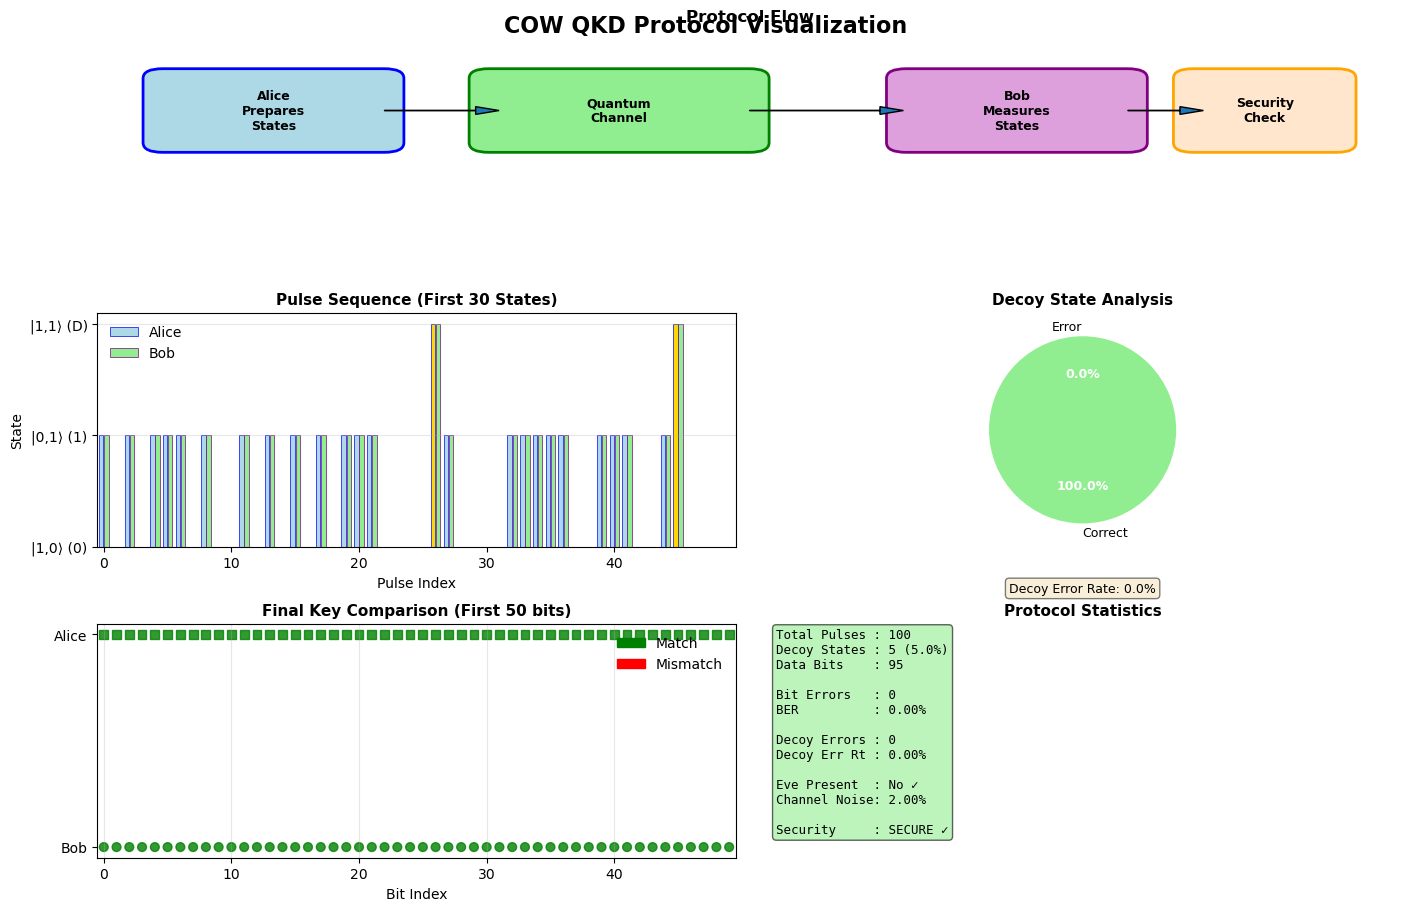

In [8]:
cow1 = COW_QKD(key_length=100, error_rate=0.02, eve_present=False)
alice_key1, bob_key1, ber1 = cow1.run_protocol()
cow1.visualize_protocol()

## Scenario 2 – With Eavesdropper (Intercept–Resend Attack)

- `eve_present = True`
- Eve randomly measures and resends the pulses

Run this cell and compare BER, decoy error rate, and security status with Scenario 1.

COW QKD Protocol Simulation
Key length: 100
Channel error rate: 2.00%
Eve present: True

Step 1: Alice prepares quantum states...
Step 2: Transmission through quantum channel...
Step 3: Bob measures received states...

Step 4: Key sifting and security check...
Decoy state error rate: 36.36%
⚠️ HIGH DECOY ERROR RATE - Eavesdropping detected!
Aborting key exchange for security.


C:\Users\BIKASH CHANDRA NAYAK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


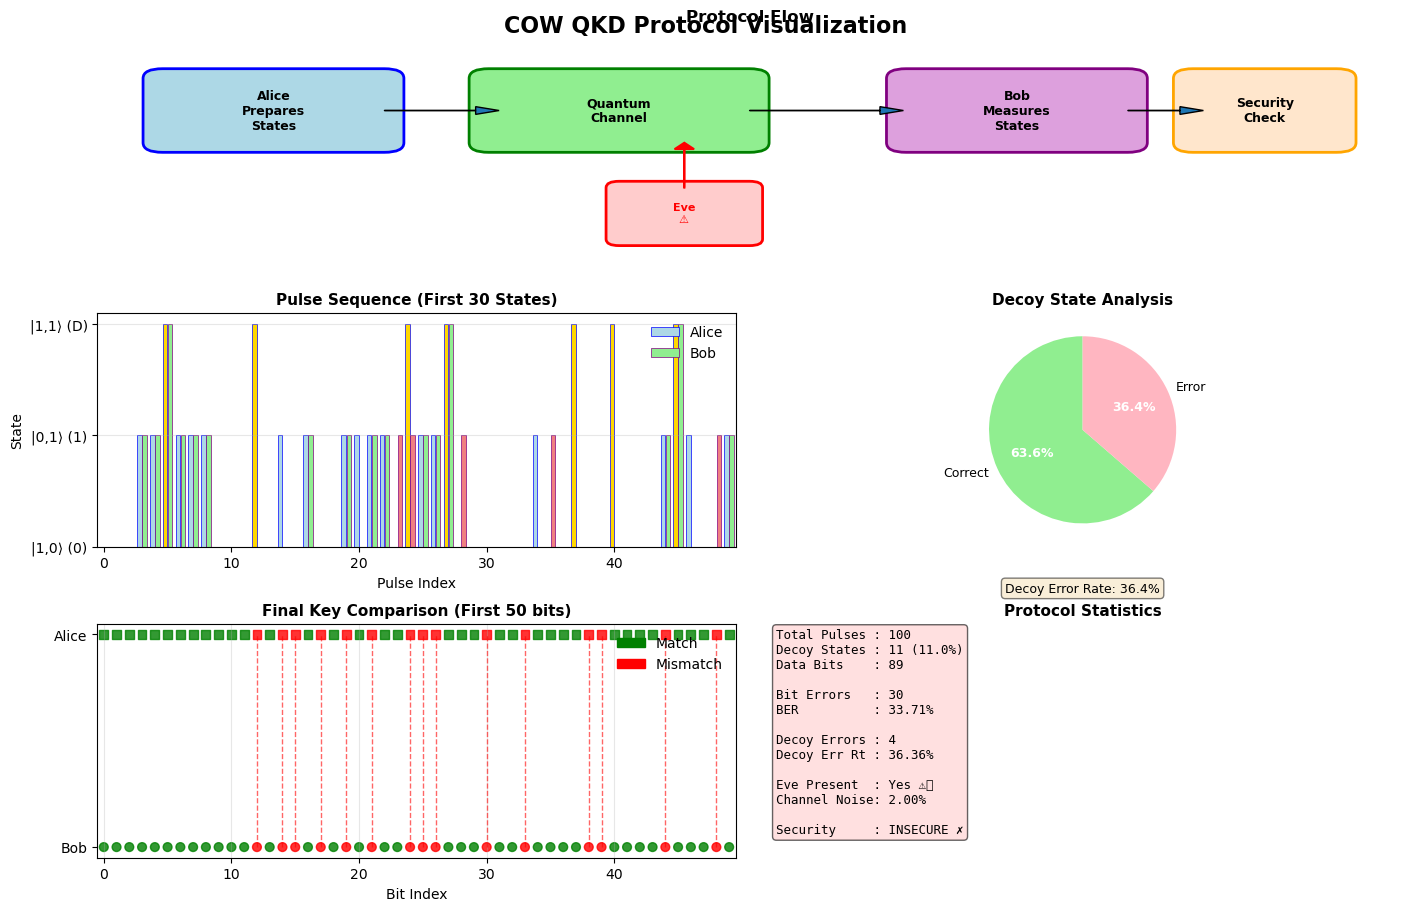

In [6]:
cow2 = COW_QKD(key_length=100, error_rate=0.02, eve_present=True)
alice_key2, bob_key2, ber2 = cow2.run_protocol()
cow2.visualize_protocol()

## Playground – Try Your Own Parameters

Modify the parameters below:
- `key_length` – number of pulses / bits
- `error_rate` – channel noise (0.0–0.2)
- `eve_present` – toggle eavesdropper

Observe how **BER**, **decoy error rate**, and **security status** change.

COW QKD Protocol Simulation
Key length: 150
Channel error rate: 5.00%
Eve present: True

Step 1: Alice prepares quantum states...
Step 2: Transmission through quantum channel...
Step 3: Bob measures received states...

Step 4: Key sifting and security check...
Decoy state error rate: 50.00%
⚠️ HIGH DECOY ERROR RATE - Eavesdropping detected!
Aborting key exchange for security.


C:\Users\BIKASH CHANDRA NAYAK\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


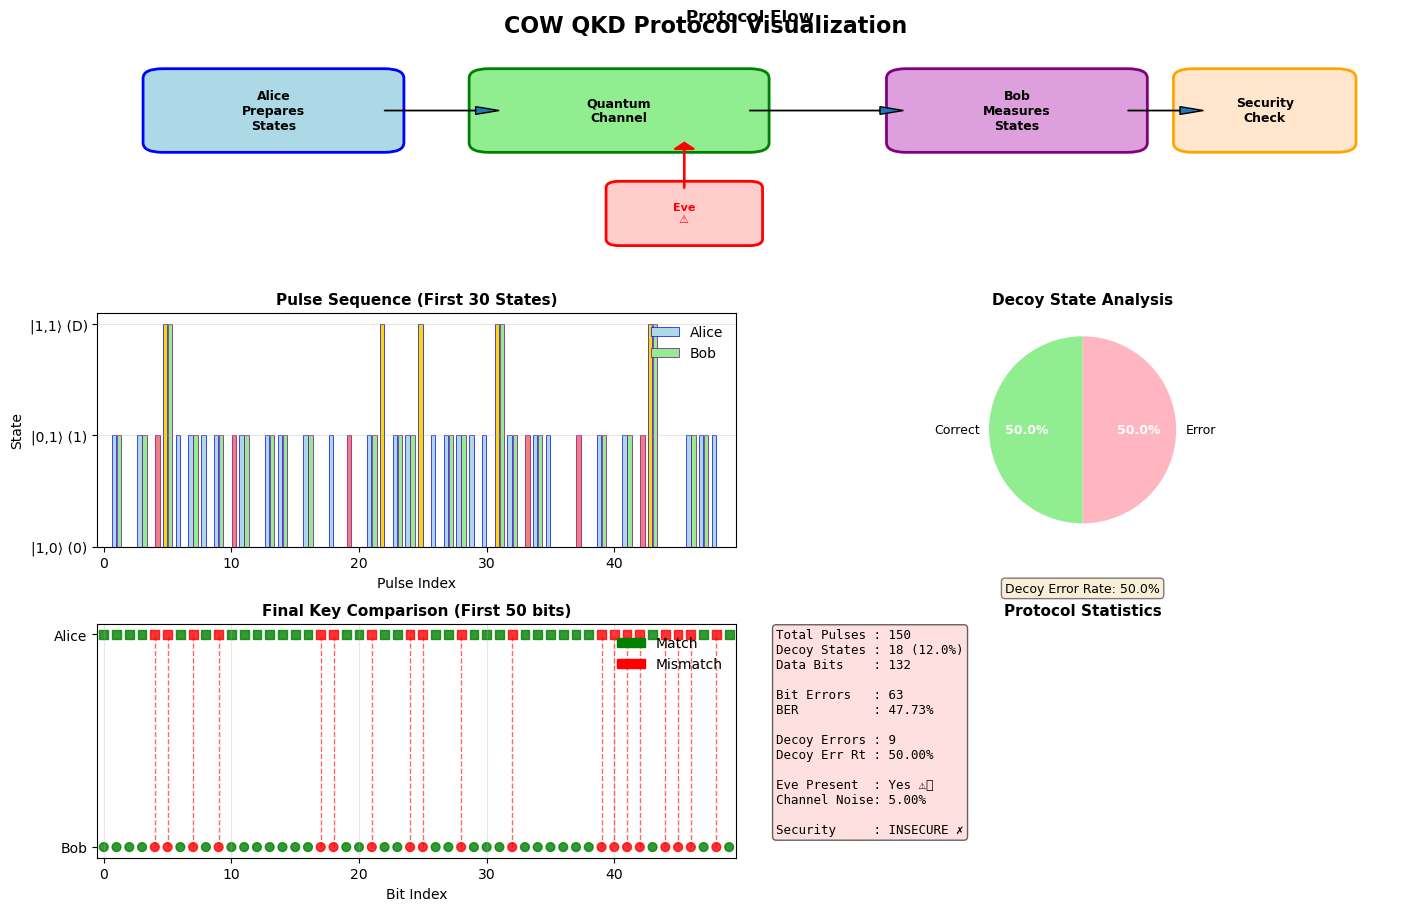

In [7]:
# Feel free to change these values
key_length = 150
error_rate = 0.05
eve_present = True

cow_custom = COW_QKD(key_length=key_length, error_rate=error_rate, eve_present=eve_present)
alice_key_c, bob_key_c, ber_c = cow_custom.run_protocol()
cow_custom.visualize_protocol()